Homework 4:
---
For this homework we will be building various neural networks to classify handwritten digits.

### Question 1: Feed-Forward Neural Network to classify MNIST digits.

Train a neural network to classify MNIST digits. Remember we have to pick 3 different components to build a neural network: (1) Network Architecture (2) Loss Function and (3) Optimizer. For this assignment use the following:

Network Architecture:
* [28x28] input 
* -> Use a view to reshape to [784]
* -> Linear Layer [784, Num Hidden Units]
* -> Relu
* -> Output Linear Layer [NumHiddenUnits, 10]
* -> Log Softmax (`torch.nn.functional.log_softmax(output)`)

Loss: Please use the negative log likelihood loss function (nll_loss).
Optimizer: Please use SGD optimizer (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD), but you can also experiment with Adam optimizer in 1.6.

1.1: Create a Pytorch module to implement a version of this neural network. Display the shape of the network using ` torchsummary.summary`.

1.2 Create a training loop to train this model using SGD optimizer. Note, we should train using minibatches. The dataloader will create minibatches for you automatically and you can just loop through as follows:

```
for epoch in range(0, num_epochs):
  # Loop over the dataloader and get minibatches:
  for batch_idx, (data, target) in enumerate(train_dataloader):
    # TODO: Reset gradient on optimizer
    # TODO: Evaluate th emodel on data
    # TODO: Calculate loss using nll_loss
    # TODO: Evaluate gradient with respect to the loss function
    # TODO: Run a step of the optimizer.
    # TODO: Store the loss function for plotting every X batches.
```


1.3 Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

1.4: Create a classifier for your model. The output of your model can be evaluated by usuing the forward function, or just calling the model ```trained_nn_model(sample)```. The output of your model will be a tensor of 10 values representing the log softmax value for each class. You can build a classifier by simply taking the index with the highest value. For example if the classifier outputs `[.1, .2, .6, .1]` you would classify it as class 2.

1.5: Create and display a confusion matrix for your classifier on your Train and Test data using https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other?

1.6: Experiment with different network shapes (number of hidden layers and number of hidden units per layer) or optimizers (for example, you can try Adam instead of SGD). Report the Train and Test accuracy of at least 4 experiments here and discuss what works well and what does not.

1.7: Find some examples of images your model misclassifies. Display these images and discuss why the model does not work well on them. 

### Question 2: Convolutional Neural Network to classify MNIST digits.

We will answer similar questions as above but using a convolutional neural network. Please start with this example network module.

```
class SimpleConvNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dense_layer = nn.Linear(320, 50)      
        self.output_layer = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.dense_layer(x))
        x = F.dropout(x, training=self.training)
        output = self.output_layer(x)
        return F.log_softmax(output)
```

2.1: Create a Pytorch module to implement a version of this neural network as implemented above. Display the shape of the network using ` torchsummary.summary`.

2.2 Create a training loop to train this model using Adam optimizer. This should be similar to 1.2.

2.3 Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

2.4: Create a classifier for your model and report train and test accuracy. How does this compare to the performance of your non-convolutional neural network in question 1?

2.5: Create and display a confusion matrix for your classifier on your Train and Test data. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other? How does this differ from 1.5?

2.6: Experiment with different kernel sizes and stride parameters to your convolutions. Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.

2.7: Experiment with the network structure. Can you add in an additional convolution? Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.

In [1]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
from matplotlib import cm
import numpy as np

In [2]:
# GLOBAL CONSTANTS
num_dimensions = 28**2
num_classes = 10

In [3]:
# Load the MNIST dataset:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_train_dataset = torchvision.datasets.MNIST(
    root='../../Data/MNIST', train=True, download=True, transform=transform)
mnist_test_dataset = torchvision.datasets.MNIST(
    root='../../Data/MNIST', train=False, download=True, transform=transform)

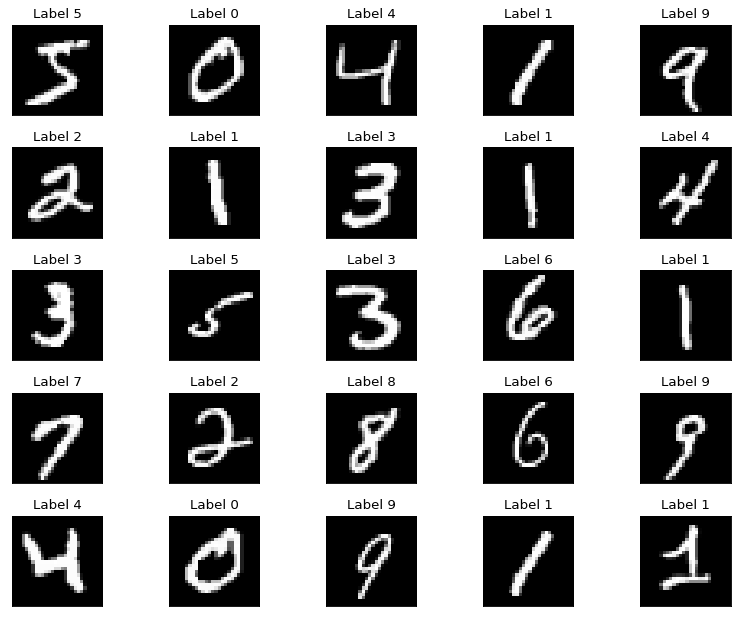

In [4]:
def image_grid(data, num_figs):
    """Function to display a grid of images
    Args:
      data: torchvision dataset
      num_figs: number of images to display
    """
    fig = figure(figsize=(10, 8), dpi=80)
    for i in range(num_figs):
        fig_i = int(math.sqrt(num_figs))
        plt.subplot(fig_i, fig_i, i+1)
        plt.tight_layout()
        image, label = data[i]
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.title(f"Label {label}")
        plt.xticks([])
        plt.yticks([])
image_grid(mnist_train_dataset, 25)

In [5]:
# Without this cell I was not able to disable gpu usage, and it gave errors since tensors were not in gpu
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
# Let's set the random seed so we will get the seame behavior each run.
random_seed = 42
torch.manual_seed(random_seed)

# Let's make sure to turn off GPU backend in case you happen to have GPU. The only
# reason we do this is not to have to worry about moving data and models on and
# off of the GPU for now. If you are training large models and have a GPU, then
# you will want to use it.
torch.backends.cudnn.enabled = False
# This worked for me to force torch to use cpu
torch.cuda.is_available = lambda : False

In [7]:
# def get_default_device():
#     """Pick GPU if available, else CPU"""
#     torch.cuda.is_available = lambda : False
#     return torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = get_default_device()

# def to_device(data, device):
#     """Move tensor(s) to chosen device"""
#     if isinstance(data, (list,tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)
    
# class DeviceDataLoader():
#     """Wrap a dataloader to move data to a device"""
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device
        
#     def __iter__(self):
#         """Yield a batch of data after moving it to device"""
#         for b in self.dl: 
#             yield to_device(b, self.device)

#     def __len__(self):
#         """Number of batches"""
#         return len(self.dl)

In [8]:
# Put training and test data into data loaders allow batching of datasets.
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=batch_size_test, shuffle=True)
# train_loader = DeviceDataLoader(train_loader, device)
# test_loader = DeviceDataLoader(test_loader, device)

Question 1.1: Create a Pytorch module to implement a version of this neural network. Display the shape of the network using ` torchsummary.summary`.

In [23]:
# Question 1.1
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(num_dimensions, 20)
        self.linear2 = nn.Linear(20, num_classes)

    def forward(self, x):
        x = x.view(-1, num_dimensions)
        z1 = self.linear(x)
        a1 = F.relu(z1)
        z2 = self.linear2(a1)
        return F.log_softmax(z2, dim=1)

nn = SimpleNeuralNet()
summary(nn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]          15,700
            Linear-2                   [-1, 10]             210
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


Question 1.2 Create a training loop to train this model using SGD optimizer. Note, we should train using minibatches. The dataloader will create minibatches for you automatically and you can just loop through as follows:

In [24]:
# Question 1.2
def train(model, epochs, training_data, minibatch_steps, optimizer, loss_function):
    errors = []
    for epochs in range(epochs):
        for batch_idx, (data, target) in enumerate(training_data):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % minibatch_steps == 0:
                errors.append(loss.item())
    return errors
# We can pass SGD as the optimizer in the parameter and F.nll_loss as loss function in the parameter
# ---------------------- Example below -------------------------------------------------------
# train(nn_model, 200, train_loader, 100, torch.optim.SGD(nn_model.parameters(), lr=1e-1), F.nll_loss) 

Question 1.3 Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

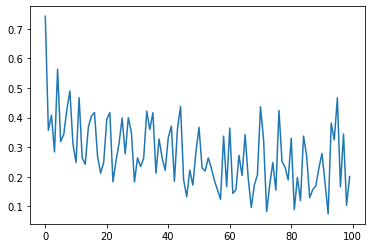

In [42]:
# Question 1.3
errors = train(nn, 10, train_loader, 100, torch.optim.SGD(nn.parameters(), lr=1e-2), F.nll_loss)  # 100 in the paramemters represents recording for every 100 minibatch steps
plt.plot(errors) 
plt.show()

Question 1.4: Create a classifier for your model. The output of your model can be evaluated by usuing the forward function, or just calling the model ```trained_nn_model(sample)```. The output of your model will be a tensor of 10 values representing the log softmax value for each class. You can build a classifier by simply taking the index with the highest value. For example if the classifier outputs `[.1, .2, .6, .1]` you would classify it as class 2.

In [12]:
# Question 1.4
def classifier(model, data):
    correct, total = 0, 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data):
            output = model(data)
            rest, predicted = torch.max(output.data, 1)
            total += target.size(0)     
            correct += (predicted == target).sum().item()
    return 100 * correct / total

print("Training Accuracy:", classifier(nn, train_loader))
print("Testing Accuracy:", classifier(nn, test_loader))

Training Accuracy: 88.28
Testing Accuracy: 88.83


Question 1.5: Create and display a confusion matrix for your classifier on your Train and Test data using https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other?

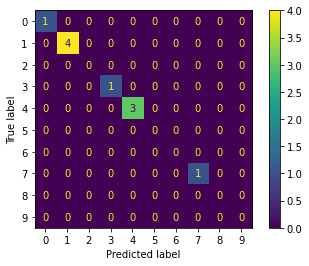

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels, predicts = [], []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        output = nn(data)
        rest, predicted = torch.max(output.data, 1)
        labels.append(target[batch_idx].item())
        predicts.append(predicted[batch_idx].item())

cm = confusion_matrix(labels, predicts, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
disp.plot()
plt.show()

Question 1.6: 
Experiment with different network shapes (number of hidden layers and number of hidden units per layer) or optimizers (for example, you can try Adam instead of SGD). Report the Train and Test accuracy of at least 4 experiments here and discuss what works well and what does not.

# Experiment 1
* In experiment 1 we will test increasing the number of hidden units while keeping the number of hidden layers the same will cause a change in the accuracy.
* The results of the next experiment will explain to us how increasing the number of hidden units will affect accuracy.

In [16]:
# Question 1.6 ---> Experiment 1
from torch import nn
class NeuralNetwork_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(num_dimensions, 40)
        self.linear2 = nn.Linear(40, num_classes)

    def forward(self, x):
        x = x.view(-1, num_dimensions)
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

# ---------------------------------SGD vs Adam optimizer---------------------------------------
# SGD optimizer
print("SGD Optimizer Results")
nn_sgd = NeuralNetwork_1()
train(nn_sgd, 1, train_loader, 100, torch.optim.SGD(nn_sgd.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(nn_sgd, train_loader))
print("Testing Accuracy:", classifier(nn_sgd, test_loader), "\n")
# Adam optimizer
print("Adam Optimizer Results")
nn_adam = NeuralNetwork_1()
train(nn_adam, 1, train_loader, 100, torch.optim.SGD(nn_adam.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(nn_adam, train_loader))
print("Testing Accuracy:", classifier(nn_adam, test_loader))

SGD Optimizer Results
Training Accuracy: 88.35333333333334
Testing Accuracy: 89.03 

Adam Optimizer Results
Training Accuracy: 88.225
Testing Accuracy: 88.98


# Experiment 1 analysis
* The NeuralNetwork_1 model had marginally better accuracies than the SimpleNeuralNet.
* Therefore, we can say that increasing the number of hidden units while keeping the number of hidden layers the same can marginally increase accuracy.
* Additionally, for NeuralNetwork_1 model the SGD Optimizer was better than the Adam Optimizer by a few percentages.

# Experiment 2
* In experiment 2 we will test if decreasing the number of hidden units while keeping the number of hidden layers the same will cause a change in the accuracy
* The results of the next experiment will explain to us how increasing the number of hidden units will affect accuracy.

In [17]:
# Question 1.6 ---> Experiment 2
class NeuralNetwork_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(num_dimensions, 15)
        self.linear2 = nn.Linear(15, num_classes)

    def forward(self, x):
        x = x.view(-1, num_dimensions)
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

# ---------------------SGD vs Adam optimizer----------------------------------
# SGD optimizer
print("SGD Optimizer Results")
nn_sgd = NeuralNetwork_2()
train(nn_sgd, 1, train_loader, 100, torch.optim.SGD(nn_sgd.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(nn_sgd, train_loader))
print("Testing Accuracy:", classifier(nn_sgd, test_loader), "\n")
# Adam optimizer
print("Adam Optimizer Results")
nn_adam = NeuralNetwork_2()
train(nn_adam, 1, train_loader, 100, torch.optim.SGD(nn_adam.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(nn_adam, train_loader))
print("Testing Accuracy:", classifier(nn_adam, test_loader))

SGD Optimizer Results
Training Accuracy: 88.075
Testing Accuracy: 88.81 

Adam Optimizer Results
Training Accuracy: 87.99666666666667
Testing Accuracy: 88.44


# Experiment 2 analysis
* The NeuralNetwork_2 model was marginally lower accuracies than the SimpleNeuralNet and NeuralNetwork_1.
* Therefore, we can say that decreasing the number of hidden units while keeping the number of hidden layers the same can marginally decrease accuracy.
* Additionally, for NeuralNetwork_2 model the SGD Optimizer was better than the Adam Optimizer by a few percentages.

# Experiment 3
* In experiment 3 we will test if increase the number of hidden layers will cause a change in the performance.
* The results of the next experiment will explain to us how increasing the number of hidden layers will affect performance.

In [18]:
# Question 1.6 ---> Experiment 3
class NeuralNetwork_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(num_dimensions, 40)
        self.linear2 = nn.Linear(40, 20)
        self.linear3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, num_dimensions)
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.log_softmax(x, dim=1)

# ---------------------SGD vs Adam optimizer----------------------------------
# SGD optimizer
print("SGD Optimizer Results")
nn_sgd = NeuralNetwork_3()
train(nn_sgd, 1, train_loader, 100, torch.optim.SGD(nn_sgd.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(nn_sgd, train_loader))
print("Testing Accuracy:", classifier(nn_sgd, test_loader), "\n")
# Adam optimizer
print("Adam Optimizer Results")
nn_adam = NeuralNetwork_3()
train(nn_adam, 1, train_loader, 100, torch.optim.SGD(nn_adam.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(nn_adam, train_loader))
print("Testing Accuracy:", classifier(nn_adam, test_loader))

SGD Optimizer Results
Training Accuracy: 85.685
Testing Accuracy: 86.19 

Adam Optimizer Results
Training Accuracy: 86.52
Testing Accuracy: 86.66


# Experiment 3 analysis
* The NeuralNetwork_3 model had lower accuracies than the SimpleNeuralNet, NeuralNetwork_1 and NeuralNetwork_2 models.
* As the results show, increasing the number of hidden layers decreased the accuracy
* Additionally, for NeuralNetwork_3 model the SGD Optimizer was better than the Adam Optimizer by a few percentages.

# Experiment 4

In [20]:
# Question 1.6 ---> Experiment 4
class NeuralNetwork_4(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(num_dimensions, 20)
        self.linear2 = nn.Linear(20, 15)
        self.linear3 = nn.Linear(15, 10)

    def forward(self, x):
        x = x.view(-1, num_dimensions)
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.log_softmax(x, dim=1)

# ---------------------SGD vs Adam optimizer----------------------------------
# SGD optimizer
print("SGD Optimizer Results")
nn_sgd = NeuralNetwork_4()
train(nn_sgd, 1, train_loader, 100, torch.optim.SGD(nn_sgd.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(nn_sgd, train_loader))
print("Testing Accuracy:", classifier(nn_sgd, test_loader), "\n")
# Adam optimizer
print("Adam Optimizer Results")
nn_adam = NeuralNetwork_4()
train(nn_adam, 1, train_loader, 100, torch.optim.SGD(nn_adam.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(nn_adam, train_loader))
print("Testing Accuracy:", classifier(nn_adam, test_loader))

SGD Optimizer Results
Training Accuracy: 83.72666666666667
Testing Accuracy: 83.89 

Adam Optimizer Results
Training Accuracy: 85.56333333333333
Testing Accuracy: 86.13


Question 1.7: Find some examples of images your model misclassifies. Display these images and discuss why the model does not work well on them.

Misclassification found!


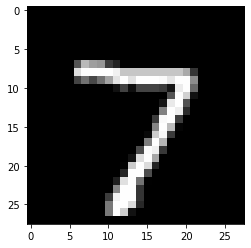

tensor(9)


In [ ]:
# Question 1.7
def misclassification(model, data):
    data_loader = torch.utils.data.DataLoader(data, batch_size=1000, shuffle=False)
    with torch.no_grad():
        for batch_idx, (data, rest) in enumerate(data_loader):
            output = model(data)
            rest, predicted = torch.max(output.data, 1)
            image, label = mnist_test_dataset[batch_idx]
            if label != predicted[len(predicted)-1]:
                print("Misclassification found!")
                plt.imshow(image.reshape(28, 28), cmap='gray')
                plt.show()
                print(predicted[len(predicted)-1])
                break

# Find misclassication with test_dataset
misclassification(nn, mnist_test_dataset)

### Question 2: Convolutional Neural Network to classify MNIST digits.
We will answer similar questions as above but using a convolutional neural network. Please start with this example network module.

In [ ]:
# CNN Model
class SimpleConvNetModel(nn.Module):
    def __init__(self):
        super(SimpleConvNetModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

cnn = SimpleConvNetModel()
summary(cnn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


* Question 2.2 Create a training loop to train this model using Adam optimizer. This should be similar to 1.2.
* Question 2.3 Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. 
Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

There is a function already created in Question 1.2 called train()
 <function train at 0x0000019BB59DE550>


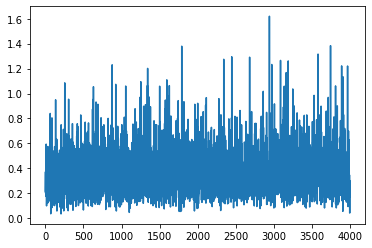

In [ ]:
# Question 2.2
# Answer to Question 2.2 in train() below <--- reusing train() function as training loop
errors = train(cnn, 1, train_loader, 100, torch.optim.Adam(cnn.parameters(), lr=1e-2), F.nll_loss) 
# Answer to Question 2.3 in train() above | the 100 parameter means that we record loss for every 100 minibatch steps
plt.plot(errors) 
plt.show()

Question 2.4: Create a classifier for your model and report train and test accuracy. How does this compare to the performance of your non-convolutional neural network in question 1?

In [ ]:
# Question 2.4 <--- Function reused from 1.4
print("Training Accuracy:", classifier(cnn, train_loader))
print("Testing Accuracy:", classifier(cnn, test_loader))

Training Accuracy: 90.21833333333333
Testing Accuracy: 90.62


2.5: Create and display a confusion matrix for your classifier on your Train and Test data. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other? How does this differ from 1.5?

2.6: Experiment with different kernel sizes and stride parameters to your convolutions. Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.

2.7: Experiment with the network structure. Can you add in an additional convolution? Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.